<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/COMPAS_data_inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
import os

# Specify the directory path
directory_path = '//Users/mirthedankloff/Documents/XAI_Bias_Error/COMPAS'

# Traverse the directory and print the names of all files
for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Load cleaned Compas data

In [ ]:
#compas_s = pd.read_csv("/content/final_preprocessed_compas(2).csv")
#ofercompas = pd.read_csv("/content/propublica_data_for_fairml.csv")
#originalcompas = pd.read_csv("/content/compas-scores-two-years-violent.csv")
#cox_violent_filt = pd.read_csv('/content/cox-violent-parsed_filt.csv')
compas_2 = pd.read_csv('/content/cleaned_compas_data.csv')

In [ ]:
compas_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       7214 non-null   int64 
 1   sex                      7214 non-null   object
 2   age                      7214 non-null   int64 
 3   age_cat                  7214 non-null   object
 4   race                     7214 non-null   object
 5   decile_score             7214 non-null   int64 
 6   priors_count             7214 non-null   int64 
 7   is_recid                 7214 non-null   int64 
 8   is_violent_recid         7214 non-null   int64 
 9   score_text               7214 non-null   object
 10  v_decile_score           7214 non-null   int64 
 11  priors_count.1           7214 non-null   int64 
 12  event                    7214 non-null   int64 
 13  two_year_recid           7214 non-null   int64 
 14  sex_Female               7214 non-null  

In [ ]:
#Two targets possible: target 1 = two_year_recid and target 2 = is_recid

#target1 = 'two_year_recid'
X1 = compas_2.drop(['two_year_recid', 'id', 'score_text', 'is_recid', 'is_violent_recid', 'sex', 'age_cat', 'race'],axis=1)
Y1 = compas_2['two_year_recid']

#target2 = "is_recid"
#X2 = compas_2.drop([target2, 'id', 'score_text', 'two_year_recid', 'is_violent_recid],axis=1)
#Y2 = compas_2[target2]


# Train Random Forest Classifier

In [ ]:
#--------------Model with target 1: two_year recid----------------

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = 0.3, shuffle = True, stratify = Y1)

model = RandomForestClassifier()
model.fit(X1_train, Y1_train)

#predictions
Y1hat = model.predict(X1_test)
len(Y1hat)

#---------------Model with target 2: is_recid--------------------

#X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = 0.3, shuffle = True, stratify = Y2)

#model = RandomForestClassifier()
#model.fit(X2_train, Y2_train)

#predictions
#Y2hat = model.predict(X2_test)
#len(Y2hat)


2165

# Collect the errors

In [ ]:
#Create data frame to contain the predicted and true classes - converting y_hat np to df
predictions = pd.DataFrame()
predictions['predicted_class'] = Y1hat.tolist()
predictions = predictions.set_index(X1_test.index)
predictions['true_class'] = Y1_test

#calculating the errors with the absolute value
predictions['errors'] = abs(predictions['predicted_class'] - predictions['true_class'])

#adding predictions to the test data
entire_dataset = X1_test.merge(predictions, how= 'outer', left_index = True, right_index = True)

errors = entire_dataset['errors']
df_out = entire_dataset.drop(['predicted_class', 'true_class', 'errors'], axis=1)
entire_dataset[entire_dataset['errors']==1]

#accuracy
accuracy = accuracy_score(predictions['true_class'], predictions['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")

#confusion matrix
cm = confusion_matrix(predictions['true_class'], predictions['predicted_class'])
print(cm)


Accuracy: 0.8790
[[1088  101]
 [ 161  815]]


Selecting 4 labels (FP, FN, TP, TN)

In [ ]:
def get_error_type(row):
    true_class = row['true_class']
    predicted_class = row['predicted_class']

    if true_class == predicted_class and true_class == 1:
        row['TP'] = 1
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 0
    elif true_class == predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 1
        row['FN'] = 0
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 1:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 1
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 1

    return row

#apply function to rows in data
entire_dataset = entire_dataset.apply(get_error_type, axis=1)

#print(data_pred.columns)
print(entire_dataset)

      age  decile_score  priors_count  v_decile_score  priors_count.1  event  \
2171   24             4             0               5               0      0   
3734   38             1             0               1               0      0   
2979   23             2             1               3               1      0   
2800   29             9             1               3               1      0   
4869   29             2             0               3               0      1   
...   ...           ...           ...             ...             ...    ...   
6770   23             5             0               6               0      0   
5012   34             1             2               2               2      1   
6219   38             6             7               8               7      0   
428    48             1             1               1               1      1   
1592   67             1             0               1               0      0   

      sex_Female  sex_Male  age_cat_25 

In [ ]:
if (entire_dataset['FP'] == 1).any():
    print("There's at least one occurrence of 1 in the column.")
else:
    print("There's no occurrence of 1 in the column.")

There's at least one occurrence of 1 in the column.


add categorical for error type

In [ ]:
# Extract dummy variables for error labels
error_type = entire_dataset[['TP', 'FP', 'FN', 'TN']]

# Convert 'Error_type' column to categorical
entire_dataset['Error_Type'] = error_type.idxmax(axis=1).astype('category')

# Drop the original 'TP', 'FP', 'FN', 'TN' columns if needed
# data_all.drop(['TP', 'FP', 'FN', 'TN'], axis=1, inplace=True)

entire_dataset = pd.merge(entire_dataset, compas_2[['sex', 'age_cat', 'race']], left_index=True, right_index=True)


print(entire_dataset)

      age  decile_score  priors_count  v_decile_score  priors_count.1  event  \
2171   24             4             0               5               0      0   
3734   38             1             0               1               0      0   
2979   23             2             1               3               1      0   
2800   29             9             1               3               1      0   
4869   29             2             0               3               0      1   
...   ...           ...           ...             ...             ...    ...   
6770   23             5             0               6               0      0   
5012   34             1             2               2               2      1   
6219   38             6             7               8               7      0   
428    48             1             1               1               1      1   
1592   67             1             0               1               0      0   

      sex_Female  sex_Male  age_cat_25 


Barchart 4 labels (FP, FN, TP, TN)

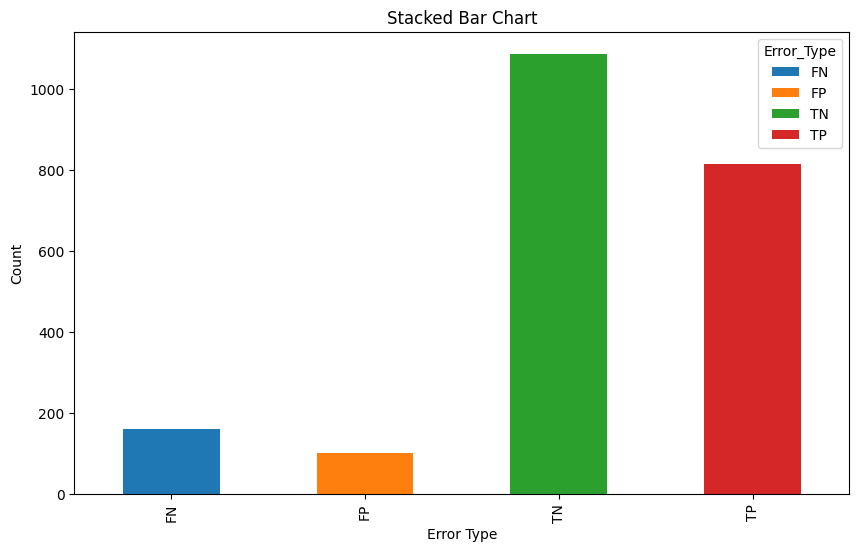

In [ ]:
errors_df = entire_dataset[['TP', 'FP', 'FN', 'TN']]

# Melt the DataFrame for easy plotting
melted_df = pd.melt(errors_df, var_name='Error_Type', value_name='Count')

# Pivot the DataFrame for stacked bar chart
pivot_df = melted_df.pivot_table(index='Error_Type', columns='Error_Type', values='Count', aggfunc='sum', fill_value=0)

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.title('Stacked Bar Chart')

# Show the plot
plt.show()


# Barchart error labels per demographic group

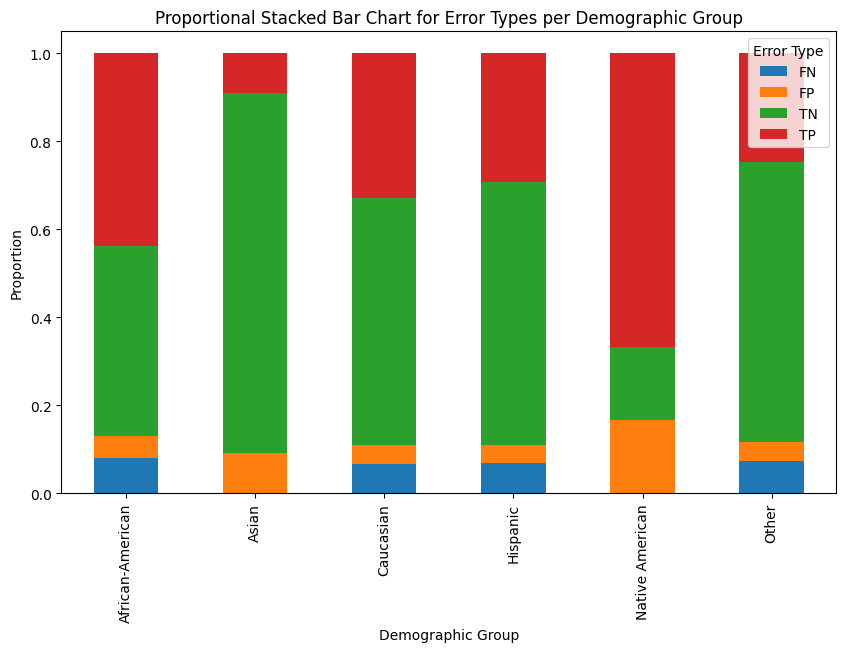

In [ ]:
#Group data by 'race' and 'Error_Type' and count occurrences
race_error_counts = entire_dataset.groupby(['race', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
race_error_proportions = race_error_counts.div(race_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
race_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Demographic Group')
plt.xlabel('Demographic Group')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()



# Barchart error labels per gender

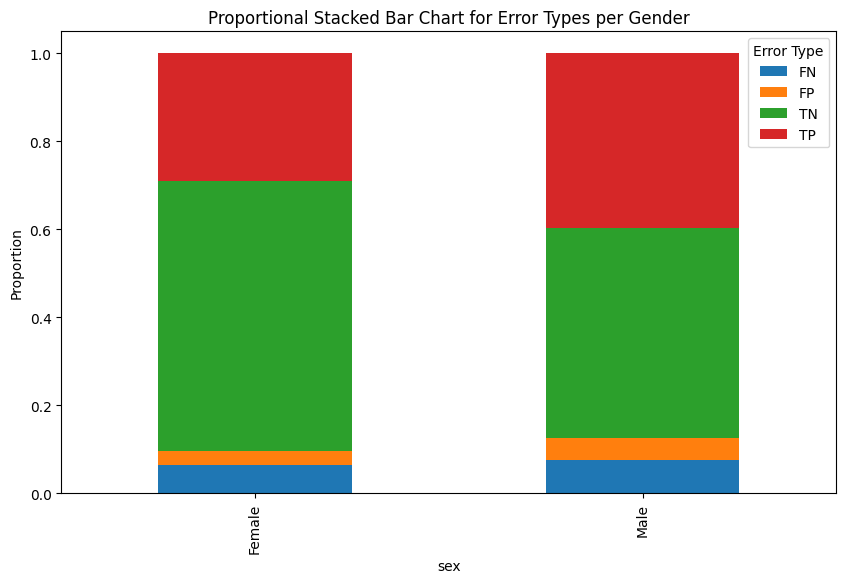

In [ ]:
#Group data by 'race' and 'Error_Type' and count occurrences
sex_error_counts = entire_dataset.groupby(['sex', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
sex_error_proportions = sex_error_counts.div(sex_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
sex_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Gender')
plt.xlabel('sex')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()

# Bar Chart Error labels per Age

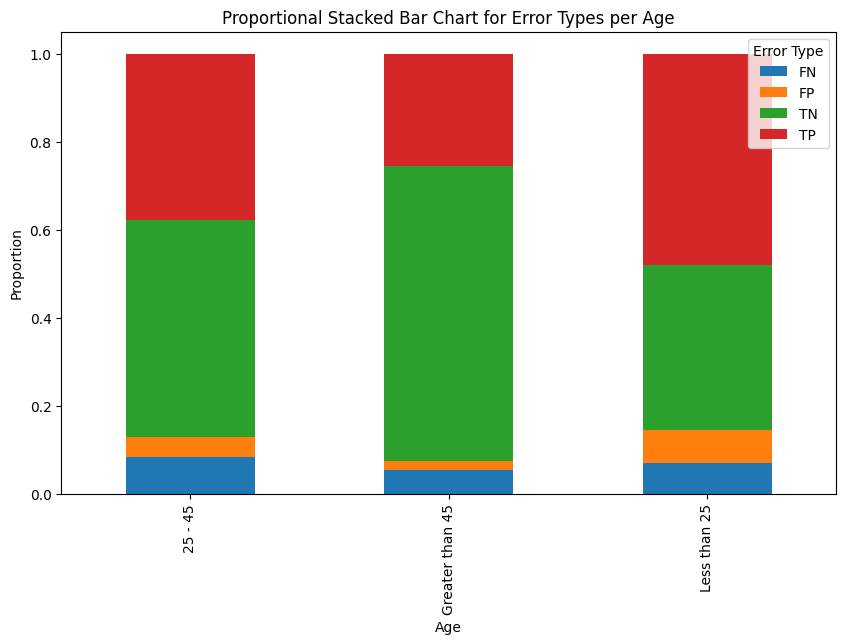

In [ ]:
# Group data by 'age' and 'Error_Type' and count occurrences
age_error_counts = entire_dataset.groupby(['age_cat', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
age_error_proportions = age_error_counts.div(age_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
age_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Age')
plt.xlabel('Age')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()


# Boxplot error label per age with jitter

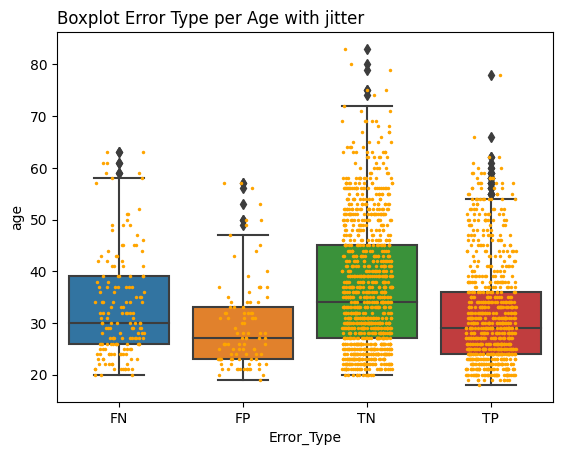

In [ ]:
# boxplot
ax = sns.boxplot(x='Error_Type', y='age', data=entire_dataset)
# add stripplot
ax = sns.stripplot(x='Error_Type', y='age', data=entire_dataset, color="orange", jitter=0.2, size=2.5)

# add title
plt.title("Boxplot Error Type per Age with jitter", loc="left")

# show the graph
plt.show()

# Scatterplot

In [ ]:
# Specify the dummy columns you want to access
race_cat = ['race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native-American', 'race_other']

# Use the 'hue' argument to provide a factor variable
sns.lmplot( x=race_cat, y="age", data=entire_dataset, fit_reg=False, hue='Error_Type', legend=False)


# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

plt.show()

TypeError: '<' not supported between instances of 'str' and 'list'

# Bubbleplot